In [1]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets
from torchvision.transforms  import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, ConfusionMatrix
from tqdm.auto import tqdm
import random
import mlxtend

/tmp/ipykernel_748/2293960687.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # get data, data train and test
file = "./my_dataset/FashionMNIST/"
if os.path.exists(file):
    download_file = False
else:
    download_file = True

train_data = datasets.FashionMNIST( root=("./my_dataset/"), 
                                    train=True,       # do we want the training dataset
                                    download=download_file,
                                    transform = torchvision.transforms.ToTensor(), # how do we want to transform the data
                                    target_transform=None) # how do we want to transform the label

test_data = datasets.FashionMNIST( root=("./my_dataset/"), train=False, download=download_file, transform= ToTensor(), target_transform=None)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape:torch.Size([1, 28, 28]) -> [color_channel, height, width]
Image label:Ankle boot


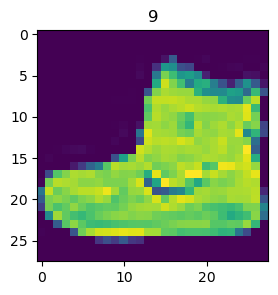

In [6]:
# check the shape of our image
image, label = train_data[0]
print(f"Image shape:{image.shape} -> [color_channel, height, width]")
print(f"Image label:{class_names[label]}")
plt.figure(figsize=(4,3))
plt.imshow(image.squeeze())
plt.title(label);

(-0.5, 27.5, 27.5, -0.5)

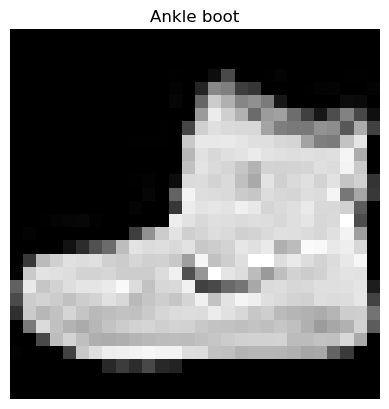

In [7]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False);

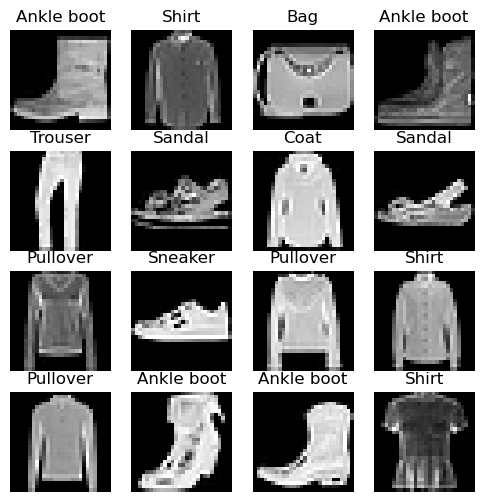

In [8]:
torch.manual_seed(42)
fig = plt.figure(figsize=(6, 6))
col, row = 4, 4
for i in range(1, col* row + 1):
    random_idx = torch.randint(0, len(train_data), size=[1] ).item()
    image, label = train_data[random_idx]
    fig.figure.add_subplot(row,col,i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [9]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./my_dataset/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./my_dataset/
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [10]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
dev

'cuda'

In [11]:
# prepare DataLoader
BATCH_SIZE = 32 # divide el dataseth en n partes

train_dataloader = DataLoader(dataset= train_data, batch_size=BATCH_SIZE,
                              shuffle= True) # realiza un random a las imagenes, xq estan en orden
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f1870b63f70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1870b635e0>)

In [12]:
# 60000/32 and 10000/32  se hizo un batch_size
print(f"Length train: {train_dataloader}")
print(f"Length test: {test_dataloader}")
print(f"Image shape: {image.shape}")

Length train: <torch.utils.data.dataloader.DataLoader object at 0x7f1870b63f70>
Length test: <torch.utils.data.dataloader.DataLoader object at 0x7f1870b635e0>
Image shape: torch.Size([1, 28, 28])


In [13]:
# build base model
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape , output_shape, hidden_units):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # change [color_channel, height, weigth] to [color_channel, height * weight]
            nn.Linear(in_features=input_shape, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
# input 28*28
model_0 = FashionMNISTModelV0(input_shape=784, output_shape=len(class_names), hidden_units=10).to(dev)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [14]:
# loss, optimizer and accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
acc_fn = Accuracy(task="multiclass", num_classes= len(class_names)).to(dev)

### Model standar

In [85]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# epochs = 3

# for epoch in tqdm(range(epochs)):
    
#     train_loss = 0
#     print(f"Epoch: {epoch} \n------")
    
#     # Train
#     for batch, (x_train,y_train) in enumerate(train_dataloader):
#         x_train, y_train = x_train.to(dev), y_train.to(dev)
#         model_0.train()
#         y_pred = model_0(x_train)
#         loss = loss_fn(y_pred, y_train)
#         train_loss += loss
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 400 == 0:
#             print(f"Looked at {batch * len(x_train)} / {len(train_dataloader.dataset)}")
    
#     train_loss /= len(train_dataloader)
    
#     # Testing
#     test_loss, test_acc = 0, 0
#     model_0.eval()
#     with torch.inference_mode():
#         for x_test, y_test in test_dataloader:
#             x_test, y_test = x_test.to(dev), y_test.to(dev)
#             test_pred = model_0(x_test)
#             test_loss += loss_fn(test_pred, y_test)
#             test_acc += acc_fn(y_test, test_pred.argmax(dim=1))
        
#         test_loss /= len(test_dataloader)
#         test_acc /= len(test_dataloader)
    
#     print(f"\nTrain loss:{train_loss:.4f} | Test loss:{test_loss:.4} | Test acc: {test_acc:.4}%\n")


### Model with def

In [18]:
# train step 
def train_step(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer, acc_fn, dev:torch.device=dev):
    
    train_loss, train_acc = 0,0

    model.to(dev)
    for batch, (x,y) in enumerate(data_loader):
            
            x, y = x.to(dev), y.to(dev)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += acc_fn(y, y_pred.argmax(dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss:{train_loss:.3f} | Train acc: {train_acc:.3f}%")

# Testing step ======
def test_step(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: nn.Module,
              optimizer: torch.optim.Optimizer, acc_fn, dev:torch.device=dev):
       
    test_loss, test_acc = 0, 0
    
    model.to(dev)
    model.eval()
    with torch.inference_mode():            
        for x, y in data_loader:
             
            x, y = x.to(dev), y.to(dev)
            test_pred = model(x)
            test_loss += loss_fn(test_pred, y)
            test_acc += acc_fn(y, test_pred.argmax(dim=1))
    
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss:{test_loss:.3f} | Test acc: {test_acc:.3f}%")


In [87]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n-------")
    train_step(model= model_0, data_loader= train_dataloader,loss_fn=loss_fn,
               optimizer=optimizer, acc_fn=acc_fn, dev=dev )

    test_step(model= model_0, data_loader= test_dataloader,loss_fn=loss_fn,
               optimizer=optimizer, acc_fn=acc_fn, dev=dev )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
-------
Train loss:0.955 | Train acc: 0.668%


 33%|███▎      | 1/3 [00:03<00:07,  3.67s/it]

Test loss:0.861 | Test acc: 0.697%
Epoch: 1 
-------
Train loss:0.820 | Train acc: 0.702%


 67%|██████▋   | 2/3 [00:07<00:03,  3.65s/it]

Test loss:0.838 | Test acc: 0.707%
Epoch: 2 
-------
Train loss:0.795 | Train acc: 0.708%


100%|██████████| 3/3 [00:11<00:00,  3.68s/it]

Test loss:0.812 | Test acc: 0.702%


In [23]:
# Get Results dictionary for Model
torch.manual_seed(42)

def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, acc_fn, device: torch.device = dev):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += acc_fn(y, y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, acc_fn=acc_fn,device=dev)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 2.315896987915039,
 'model_acc': tensor(0.0709, device='cuda:0')}

# Build Convolutional Neural Network (CNN o ConvNets)

In [19]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units) :
        super().__init__()
        
        # Conv2d xq la imagen es 2D
        # input_shape = color_channel = image gray = 1
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels= hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # otra forma
        )
        self.block_3 = nn.Sequential(
            nn.Flatten(),
            # size Image = 28*28 -> Se usa 2 veces MaxPool2d con kernel de 2, entonces 28/(2*2) = 7 para W y H o usar la nota de abajo
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        #print(f"Output shape of block 2: {x.shape}")     # A TRAVES DE ESTE SHAPE, SE PUEDE OBTENER EL 7*7 PARA nn.Linear
        return self.block_3(x)

torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=1, output_shape=len(class_names), hidden_units=10).to(dev) # 1 for color_channel
model_1

FashionMNISTModelV1(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [20]:
# loss, optimizer and accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr= 0.1)
acc_fn = Accuracy(task="multiclass", num_classes= len(class_names)).to(dev)

In [21]:
# train and test using functions
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch} \n-------")

    train_step(model=model_1, data_loader=train_dataloader, loss_fn= loss_fn, 
               optimizer=optimizer, acc_fn=acc_fn, dev=dev)

    test_step(model=model_1, data_loader=test_dataloader, loss_fn= loss_fn,
              optimizer=optimizer, acc_fn=acc_fn, dev=dev)   

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0 
-------
Train loss:0.608 | Train acc: 0.780%


 33%|███▎      | 1/3 [00:06<00:13,  6.50s/it]

Test loss:0.404 | Test acc: 0.858%
epoch: 1 
-------
Train loss:0.362 | Train acc: 0.870%


 67%|██████▋   | 2/3 [00:11<00:05,  5.48s/it]

Test loss:0.347 | Test acc: 0.877%
epoch: 2 
-------
Train loss:0.321 | Train acc: 0.884%


100%|██████████| 3/3 [00:16<00:00,  5.38s/it]

Test loss:0.319 | Test acc: 0.885%


In [24]:
model_1_results = eval_model(model=model_1, data_loader= test_dataloader, loss_fn=loss_fn, acc_fn=acc_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.3187443017959595,
 'model_acc': tensor(0.8846, device='cuda:0')}

In [25]:
# Compare model results 
compare_results = pd.DataFrame([model_0_results, model_1_results ])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,2.315897,"tensor(0.0709, device='cuda:0')"
1,FashionMNISTModelV1,0.318744,"tensor(0.8846, device='cuda:0')"


In [35]:
# Make and evaluate random predictions with best model
def make_predictions(model: nn.Module, data:list, dev:torch.device=dev):
    pred_probs=[]
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(dev)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [42]:
## Create test sample random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=10):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 6 (Shirt)


In [43]:
pred_probs= make_predictions(model=model_1, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

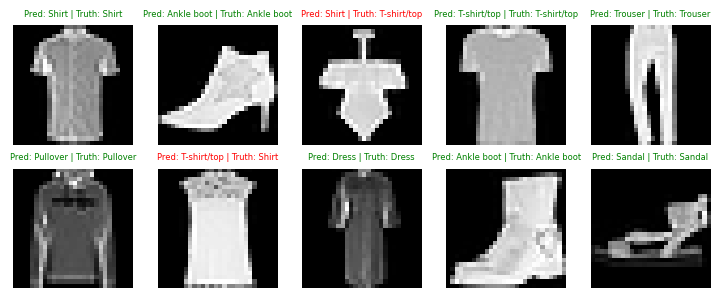

In [44]:
# plot image
plt.figure(figsize=(9, 9))
nrows = 5
ncols = 5
for i, sample in enumerate(test_samples):
  
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=6, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=6, c="r") # red text if wrong
  plt.axis(False);

In [47]:
## Confusion Matrix
conf_matrix = ConfusionMatrix("multiclass",num_classes=len(class_names))